In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

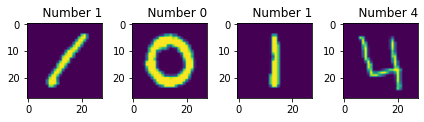

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=4)
for i in range(4):
    ax[i].set_title("    Number {}".format(df.loc[i][0]))
    ax[i].imshow(np.array(df.loc[i][1:]).reshape(28,28))
fig.tight_layout()
plt.show()

In [9]:
train, dev = train_test_split(df,test_size = 0.2, random_state = 42)

# Baseline Model

In [54]:
logreg = LogisticRegression(multi_class='multinomial')
logreg.fit(train.drop('label',axis=1),train.label)
logreg_pred = logreg.predict(dev.drop('label',axis=1))
print("Accuracy : {}".format(round(accuracy_score(dev.label,logreg_pred),4)))

Accuracy : 0.9183


In [28]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(train.drop('label',axis=1),train.label)
knn_pred = knn.predict(dev.drop('label',axis=1))
print("Accuracy : {}".format(round(accuracy_score(dev.label,knn_pred),4)))

Accuracy : 0.9687


In [63]:
svc = SVC()
svc.fit(train.drop('label',axis=1),train.label)
svc_pred = svc.predict(dev.drop('label',axis=1))
print("Accuracy : {}".format(round(accuracy_score(dev.label,svc_pred),4)))

Accuracy : 0.9735


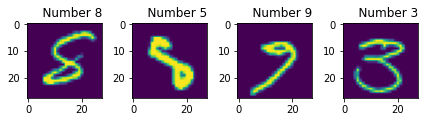

In [46]:
difference = pred - dev.label

fig, ax = plt.subplots(nrows=1, ncols=4)
for idx,i in enumerate(list(difference[difference!=0].index)[:4]):
    ax[idx].set_title("    Number {}".format(dev.loc[i][0]))
    ax[idx].imshow(np.array(dev.loc[i][1:]).reshape(28,28))
fig.tight_layout()
plt.show()